In [1]:
import pandas as pd
import numpy as np
import demoji

from collections import Counter

from wordcloud import WordCloud

import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize.casual import EMOTICON_RE
from pandarallel import pandarallel

from reviews.preprocess import preprocess, strip_html
from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Data Cleaning

## Products

In [8]:
prod_df = pd.read_json(processed_data_dir / "meta.json.gz")
prod_df = prod_df.reindex(sorted(prod_df.columns), axis=1)  # sort columns
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   asin         32720 non-null  object
 1   brand        32720 non-null  object
 2   category     32720 non-null  object
 3   description  32720 non-null  object
 4   price        32720 non-null  object
 5   title        32720 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [5]:
prod_df.head(10)

,asin,brand,category,description,price,title
0,7500653883,ECS Elitegroup,"[Electronics, Computers & Accessories, Compute...",[],,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,"[Electronics, Computers & Accessories, Compute...","[Mygica EZgrabber2 USB 2.0 Video Capture, VHS ...",,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,"[Electronics, Computers & Accessories, Compute...",[],,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,"[Electronics, Computers & Accessories, Compute...",[APC 650 VA Uninterruptable Power Supply],,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,"[Electronics, Computers & Accessories, Compute...",[Based on the award-winning Sound Blaster 16 t...,$2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,"[Electronics, Computers & Accessories, Compute...",[Monster Sound MX300 is the new-generation PCI...,,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,"[Electronics, Computers & Accessories, Compute...","[Based on the NVIDIA RIVA TNT Ultra chip set, ...",,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,"[Electronics, Computers & Accessories, Compute...",[Adding memory to your new or existing desktop...,,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Transform Data

In [ ]:
# keep the first subcategory
prod_df["category"] = prod_df["category"].parallel_apply(
    lambda x: x[4] if len(x) > 4 else "other"
)

# join description in a single string
prod_df["description"] = prod_df["description"].parallel_apply(lambda x: " ".join(x))

# remove html and replace empty with NA
for col in ["category", "description", "title", "brand", "asin"]:
    prod_df[col] = prod_df[col].astype("string").parallel_apply(strip_html)
    prod_df.loc[prod_df[col] == "", col] = np.nan

# fix price
prod_df["price"] = prod_df["price"].astype("string").parallel_apply(strip_html)
prod_df["price"] = prod_df["price"].str.replace("[\$,]", "", regex=True)
prod_df.loc[prod_df["price"].str.len() == 0, "price"] = np.nan
prod_df.loc[prod_df["price"].str.len() > 20, "price"] = np.nan

In [10]:
prod_df.head(10)

,asin,brand,category,description,price,title
0,7500653883,ECS Elitegroup,Motherboards,NaN,NaN,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,Internal TV Tuner & Capture Cards,"Mygica EZgrabber2 USB 2.0 Video Capture, VHS t...",NaN,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,Internal Modems,NaN,NaN,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,Internal Power Supplies,APC 650 VA Uninterruptable Power Supply,NaN,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,Graphics Cards,Unleash incredible graphics performance!,NaN,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,Internal Sound Cards,Based on the award-winning Sound Blaster 16 te...,2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,Graphics Cards,Unleash incredible graphics performance!,NaN,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,Graphics Cards,Monster Sound MX300 is the new-generation PCI ...,NaN,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,Graphics Cards,"Based on the NVIDIA RIVA TNT Ultra chip set, D...",NaN,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,Memory,Adding memory to your new or existing desktop ...,NaN,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Convert Data Types

In [11]:
prod_df["asin"] = prod_df["asin"].astype("string")
prod_df["brand"] = prod_df["brand"].astype("category")
prod_df["category"] = prod_df["category"].astype("category")
prod_df["description"] = prod_df["description"].astype("string")
prod_df["price"] = prod_df["price"].astype("float")
prod_df["title"] = prod_df["title"].astype("string")

### Check missing or null values

In [12]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   asin         32720 non-null  string  
 1   brand        32640 non-null  category
 2   category     32719 non-null  category
 3   description  30405 non-null  string  
 4   price        15855 non-null  float64 
 5   title        32720 non-null  string  
dtypes: category(2), float64(1), string(3)
memory usage: 1.2 MB


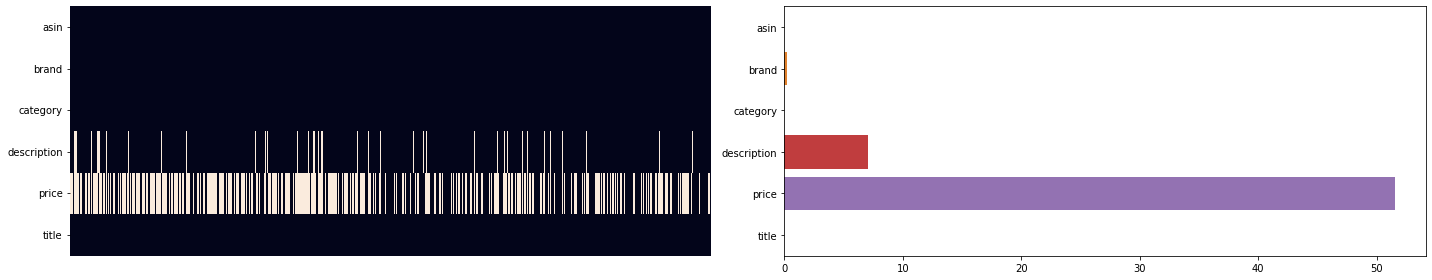

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(prod_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=prod_df.columns,
    x=(len(prod_df) - prod_df.count()) / len(prod_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

### Duplicates

In [14]:
# remove duplicates
prod_df.drop_duplicates(inplace=True)

## Reviews

In [15]:
review_df = pd.read_json(processed_data_dir / "reviews.json.gz")
review_df = review_df.reindex(sorted(review_df.columns), axis=1)  # sort columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  object        
 1   overall    269027 non-null  int64         
 2   summary    269027 non-null  object        
 3   text       269027 non-null  object        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.3+ MB


In [16]:
review_df.head(10)

,asin,overall,summary,text,timestamp,vote
0,7799813393,3,Good for what it can do.,Bought this to transfer video from some old eq...,2013-01-17,0
1,7799813393,4,works well,The EZGrabber2 works well but it's software is...,2012-09-04,0
2,7799813393,4,Cheap and it works,I got this because it was pretty decently pric...,2012-08-27,6
3,B00000J579,5,"Easy to Use, Almost everything you could want",This sound card doesn't reproduce MP3 or WAV f...,2000-10-10,32
4,B00000J579,3,Bathtub,"Essentially, this is the entry-level, 16-bit a...",2000-09-04,4
5,B00000J579,4,"Good low-end, no-hassle card",This is a basic sound card. Nothing fancy. T...,2002-07-03,6
6,B00000J579,3,Ok for the price and basic functions,This is a basic low-end sound card. It puts ou...,2002-04-04,8
7,B00000JDKU,4,good card,The Voodoo 3 is a great card that replaces bot...,1999-11-21,18
8,B00000JDKU,5,WOW!,This card is so fast and really high resolutio...,1999-07-15,4
9,B00000JF4L,5,An excellent card,Let me first state that I purchased this card ...,2000-03-15,38


### 

In [ ]:
# remove html and replace empty with NA
for col in ["asin", "overall", "summary", "text", "timestamp", "vote"]:
    review_df[col] = review_df[col].astype("string").parallel_apply(strip_html)
    review_df.loc[review_df[col] == "", col] = np.nan

### Convert Data Types

In [18]:
review_df["asin"] = review_df["asin"].astype("category")
review_df["overall"] = review_df["overall"].astype("category")
review_df["summary"] = review_df["summary"].astype("string")
review_df["text"] = review_df["text"].astype("string")
review_df["timestamp"] = pd.to_datetime(review_df["timestamp"], errors="coerce")
review_df["vote"] = review_df["vote"].astype("int")

In [19]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  category      
 1   overall    269027 non-null  category      
 2   summary    269027 non-null  string        
 3   text       269025 non-null  string        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(2)
memory usage: 9.3 MB


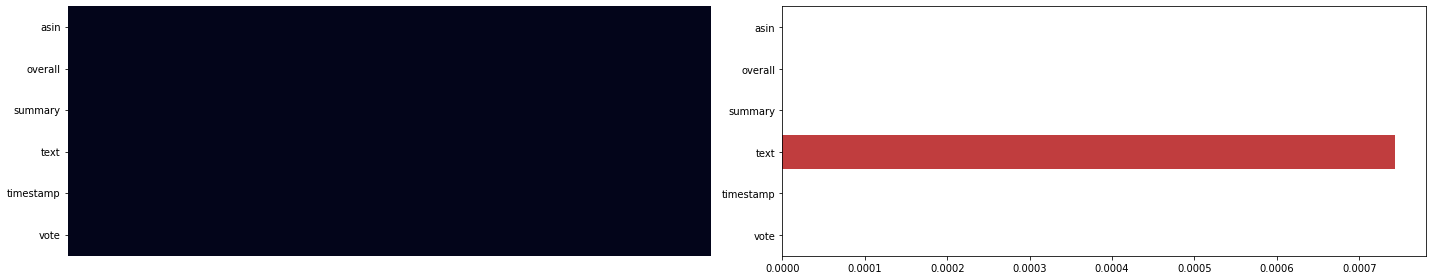

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(review_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=review_df.columns,
    x=(len(review_df) - review_df.count()) / len(review_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

In [21]:
review_df = review_df.loc[~review_df["text"].isna()]

#### Emoji

In [22]:
def find_emoji(text):
    return ", ".join(set(demoji.findall(text).keys()))


review_df["emoji"] = review_df["text"].parallel_apply(find_emoji)

In [23]:
review_df["emoji"].value_counts()

    269025
Name: emoji, dtype: int64

In [24]:
def find_emoji(text):
    return ", ".join(set(EMOTICON_RE.findall(text)))


review_df["emoji"] = review_df["text"].parallel_apply(find_emoji)

In [25]:
emoji_list = []
for emojis in set(review_df[review_df["emoji"] != ""]["emoji"].tolist()):
    emoji_list.extend(emojis.split(", "))

emoji_list = set(emoji_list)

print(emoji_list)

{'/=', '8-d', ')-8', '<:-)', '8]', '8p', '=\\', '(8', 'DO:', ':-p', '=od', ':-]', '(-:', ':@', '(o;', '\\=', '={', '=-)', ');', ':-|', 'p;', ":'(", ':/', ':{', '(O;', 'd8', '=|', 'P=', '8(', ':P', '=p', '=[', '};', '/O:', 'p:', ';-)', '@8', 'P:', ':op', '|:', "8')", ':p', '(O8', '8D', ':[', 'p8', ':d', '8d', ';-(', 'do;', ':(', ';o)', '>;-(', 'D=', ';]', '=D', '/8', '=(', 'D:', '@:', '8/', ';d', ':o(', ';P', 'P8', '>:|', '/;', '(;', '{8', 'do:', ":')", ':-P', '8P', '{:', '):', ':-D', '\\8', '|=', '[8', ':}', ')8', '8[', 'd=', 'D8', ';/', '}=', '=P', ')=', '>8)', '(=', ':-(', ';p', '8-D', ':\\', 'P;', '=d', ':-)', '[=', 'D-8', ';)', ';-|', ';(', '8@', 'p-8', '=/', ']=', '8}', "8'D", '(*8', 'D;', '8\\', ':=', "='D", ':|', 'd-8', 'po8', ':-/', '=)', '=]', '>:(', ';D', '/:', ';[', ':-\\', '8:', ']:', 'p=', 'd:', ':O)', '8)', '<3', 'po=', '8-P', ':8', 'Do;', '>:/', ':o)', ':]', '];', ':)', '(:', 'd;', '::', ':D', 'P-8', '8-p', '8{'}


### Duplicates

In [26]:
# remove duplicates
review_df.drop_duplicates(inplace=True)

### Language Detection

In [27]:
import os

if not os.path.exists("/tmp/lid.176.bin"):
    !wget -O /tmp/lid.176.bin 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'

--2022-07-25 17:34:02--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125,18M  7,91MB/s    in 15s     

2022-07-25 17:34:18 (8,28 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



In [28]:
import fasttext

from reviews.preprocess import remove_urls, strip_html, remove_numbers

model = fasttext.load_model("/tmp/lid.176.bin")

langs = []
for i, row in review_df.iterrows():
    text = row["summary"] + ". " + row["text"].replace("\n", " ")

    text = remove_urls(text)
    text = strip_html(text)
    text = remove_numbers(text)

    text = text.lower()

    lang = model.predict(text, threshold=0.9)

    if len(lang[0]) > 0:
        lang = lang[0][0].replace("__label__", "")

        if lang != "en":
            lang = "unknown"

        langs.append(lang)
    else:
        langs.append("unknown")

review_df["lang"] = langs

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [29]:
review_df["lang"].value_counts()

en         241427
unknown     27598
Name: lang, dtype: int64

In [30]:
# keep only english reviews
review_df = review_df.loc[review_df["lang"] == "en"]
review_df.drop(columns=["lang"], axis=1, inplace=True)

In [31]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241427 entries, 0 to 269026
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       241427 non-null  category      
 1   overall    241427 non-null  category      
 2   summary    241427 non-null  string        
 3   text       241427 non-null  string        
 4   timestamp  241427 non-null  datetime64[ns]
 5   vote       241427 non-null  int64         
 6   emoji      241427 non-null  object        
dtypes: category(2), datetime64[ns](1), int64(1), object(1), string(2)
memory usage: 12.0+ MB


### Merge with Products

In [32]:
data_df = pd.merge(left=review_df, right=prod_df, on="asin", copy=False)

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")

data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.reset_index(drop=True, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152363 entries, 0 to 152362
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152363 non-null  category      
 1   overall      152363 non-null  category      
 2   summary      152363 non-null  string        
 3   text         152363 non-null  string        
 4   timestamp    152363 non-null  datetime64[ns]
 5   vote         152363 non-null  int64         
 6   emoji        152363 non-null  object        
 7   brand        152363 non-null  category      
 8   category     152363 non-null  category      
 9   description  152363 non-null  string        
 10  price        152363 non-null  float64       
 11  title        152363 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1), string(4)
memory usage: 10.6+ MB


In [33]:
data_df.to_json(processed_data_dir / "products_reviews.json.gz")

# Analysis

In [2]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152363 entries, 0 to 152362
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152363 non-null  category      
 1   overall      152363 non-null  category      
 2   summary      152363 non-null  string        
 3   text         152363 non-null  string        
 4   timestamp    152363 non-null  datetime64[ns]
 5   vote         152363 non-null  int64         
 6   emoji        152363 non-null  object        
 7   brand        152363 non-null  category      
 8   category     152363 non-null  category      
 9   description  152363 non-null  string        
 10  price        152363 non-null  float64       
 11  title        152363 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1), string(4)
memory usage: 11.4+ MB


# ASIN

Mean number of reviews: 49.276520051746445


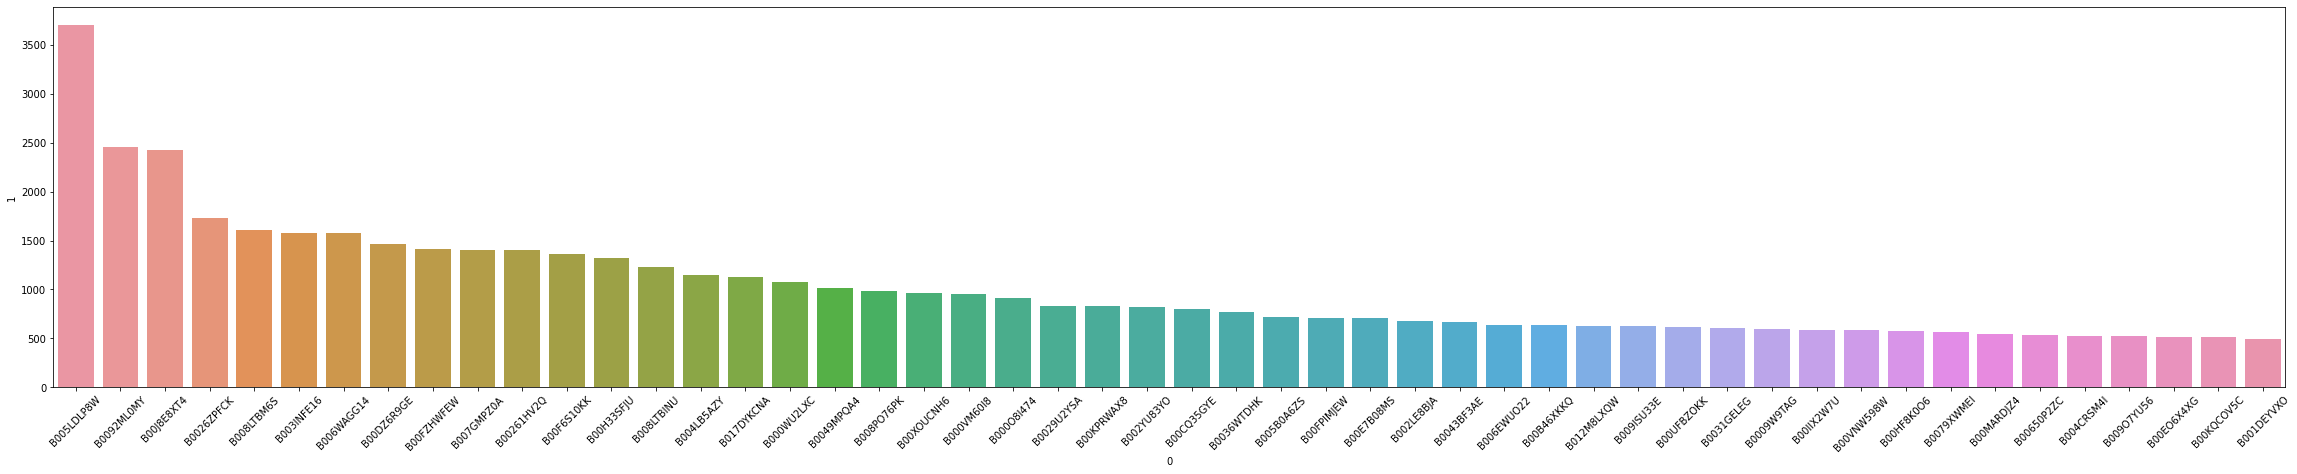

In [18]:
# number of reviews per product(ASIN)
data = pd.DataFrame(Counter(data_df["asin"].tolist()).most_common(50))
_, ax = plt.subplots(figsize=(40, 7))
plt.xticks(rotation=45)
sns.barplot(x=data[0], y=data[1], ax=ax)

# average number of reviews
z = pd.DataFrame(data_df["asin"].value_counts())
print("Mean number of reviews:", z["asin"].mean())

# Title

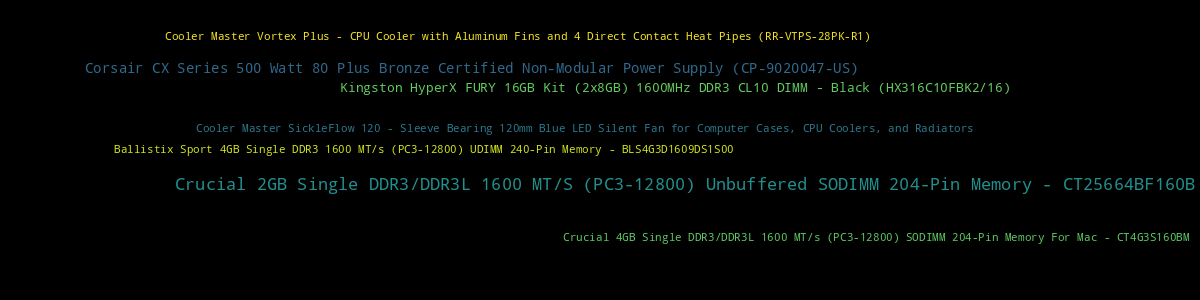

In [4]:
# most reviewed titles

c = Counter(data_df["title"].astype("string")).most_common(7)
w = WordCloud(width=1200, height=300, background_color="black").fit_words(dict(c))
w.to_image()

# Price

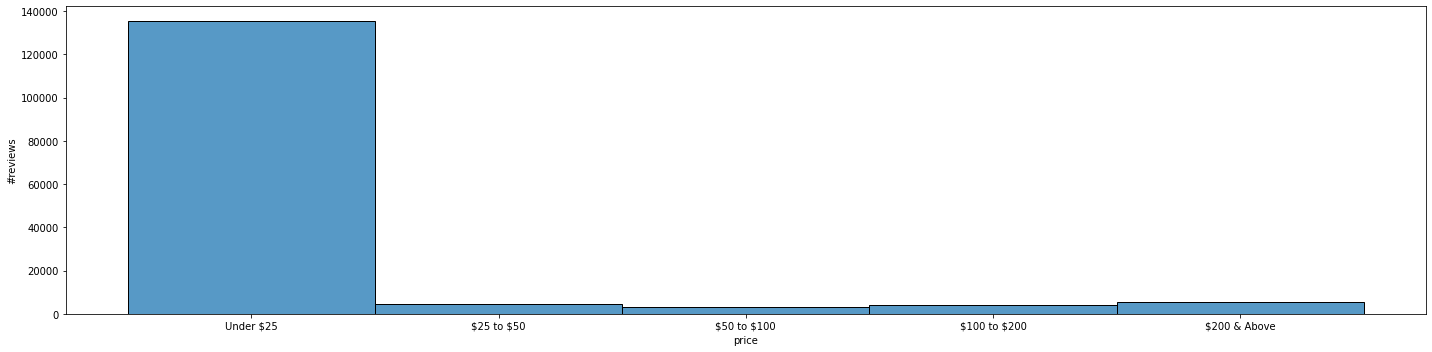

In [5]:
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)


new_price = data_df["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
new_price = new_price.astype(price_categories)


fig, ax = plt.subplots(figsize=(20, 5))
sns.histplot(new_price, ax=ax)
ax.set_ylabel("#reviews")
fig.tight_layout()

# Brand & Category

### Most Reviewed Brand

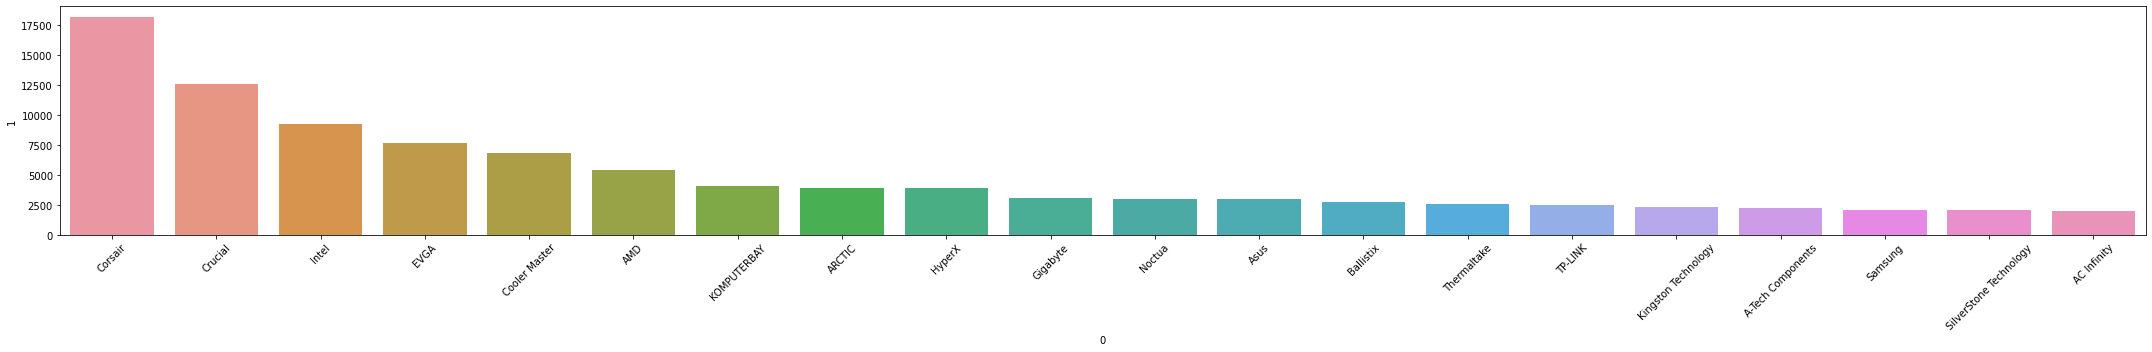

In [21]:
data = pd.DataFrame(Counter(data_df["brand"].tolist()).most_common(20))

fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()

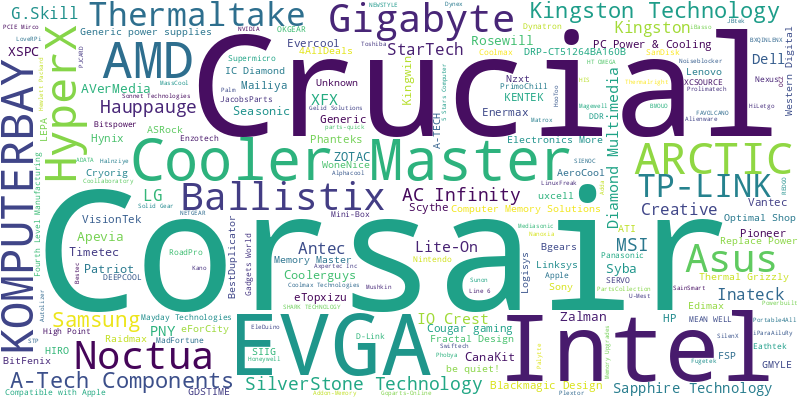

In [7]:
c = Counter(list(data_df["brand"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Most Reviewed Categories

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


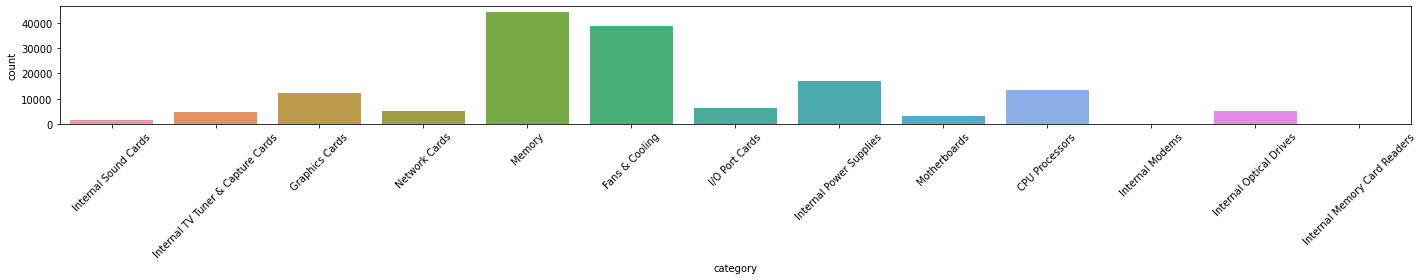

In [8]:
fig = plt.figure(figsize=(20, 4))
ax = sns.countplot(data_df["category"].astype("string"))
plt.xticks(rotation=45)
fig.tight_layout()

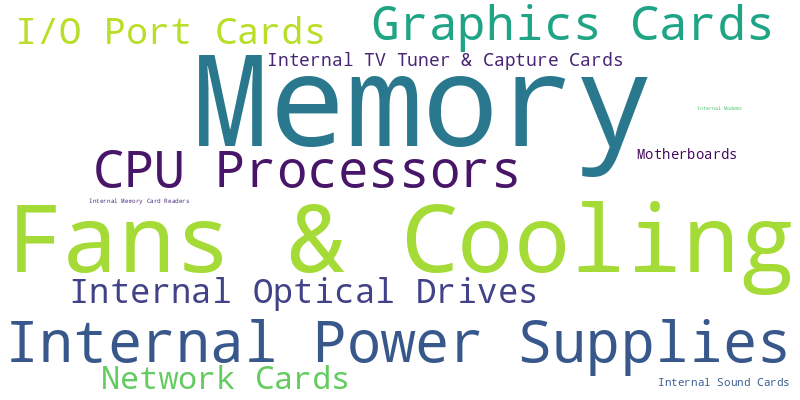

In [9]:
c = Counter(list(data_df["category"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Top 5 brand per Category

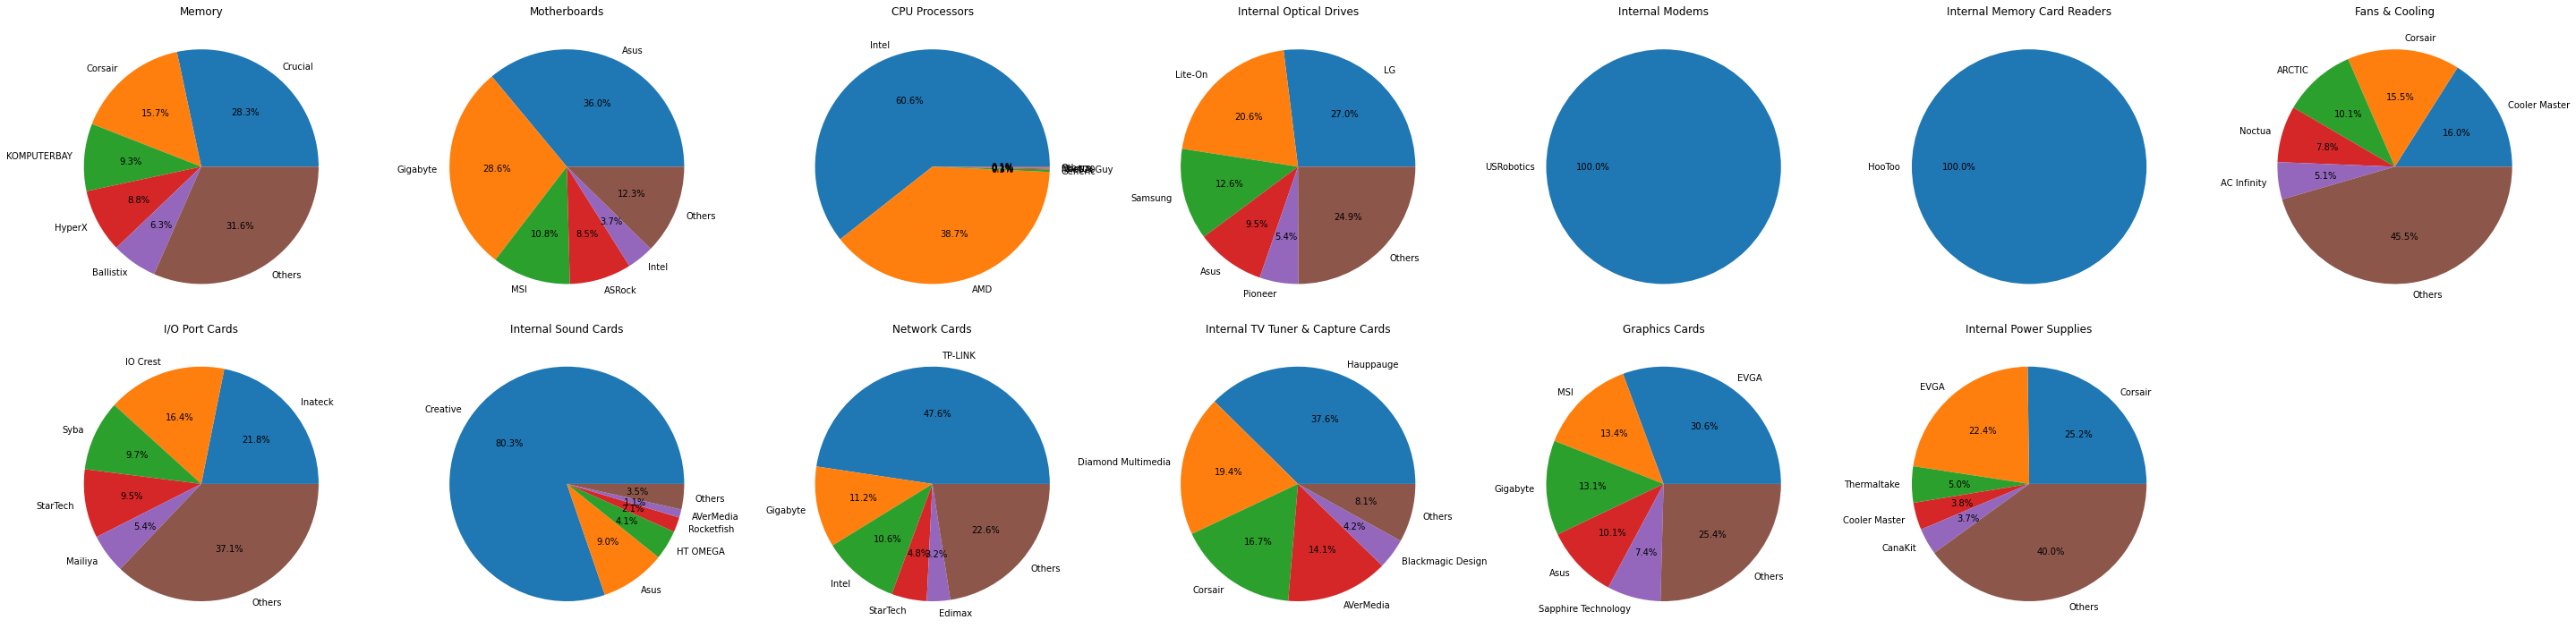

In [10]:
categories = set(data_df["category"])
fig, ax = plt.subplots(2, 7, figsize=(40, 10))
ax = ax.flatten()

for i, cat in enumerate(categories):
    z = data_df.loc[data_df["category"] == cat]["brand"]
    data = pd.DataFrame(
        Counter(z.tolist()).most_common(), columns=["brand", "count"]
    ).reset_index(drop=True)

    if len(data) > 5:
        others = pd.DataFrame(
            data={"brand": ["Others"], "count": [data["count"][5:].sum()]}
        )

        data = pd.concat([data[:5], others])

    data.set_index("brand", inplace=True)

    data.plot(
        y="count",
        x=data.index.values,
        kind="pie",
        legend=False,
        autopct="%1.1f%%",
        ax=ax[i],
    )

    ax[i].set_title(cat)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

fig.delaxes(ax[-1])
fig.tight_layout()

# Review Time Series

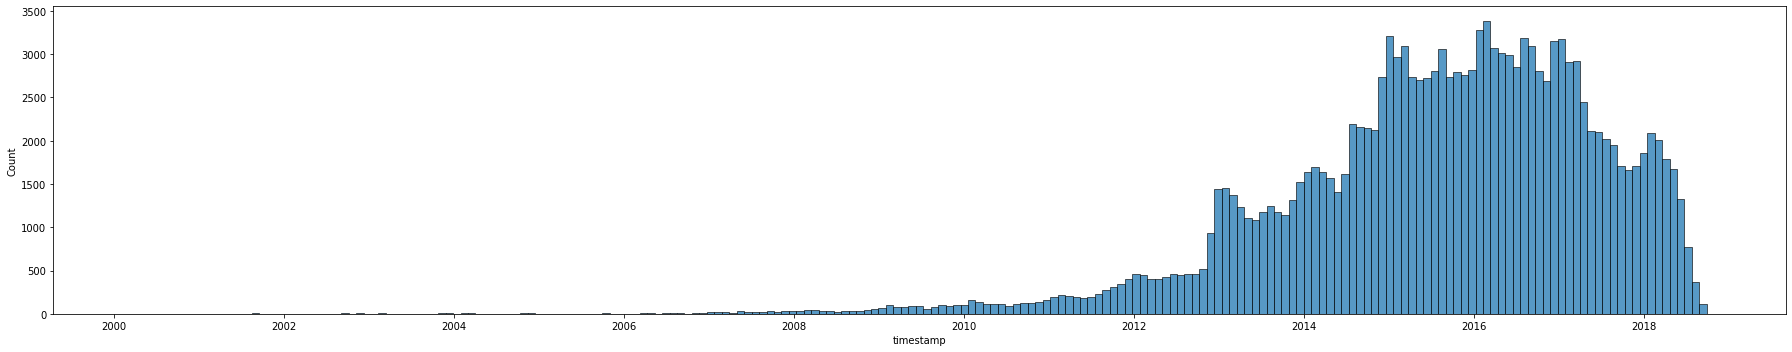

In [22]:
# number of reviews over time of the brand X

fig, ax = plt.subplots(figsize=(25, 5))
sns.histplot(data_df["timestamp"], ax=ax)
fig.tight_layout()

# Review Text and Summary

Read the data already processed

### Summary

In [12]:
data_df["summary"].head(20)

0         Easy to Use, Almost everything you could want
1                                               Bathtub
2                          Good low-end, no-hassle card
3                  Ok for the price and basic functions
4                                    Ordered by mistake
5                                  Bad out of box board
6              Creative Labs Soundblaster 16 Sound card
7                              Does not work for Dos :(
8                          An effective basic soundcard
9        Works great, if you can get it to work at all.
10                           Very useful for some tasks
11              Good tool for compressed video captrure
12    It works but prepare to spend time troubleshoo...
13       If you think AOL is GREAT, don't buy a Dazzle.
14    Never buy a PCI TV Card!  ATI TV cards are gre...
15                                         Good product
16     If it works for you then you are in the minority
17                             More like the TV 

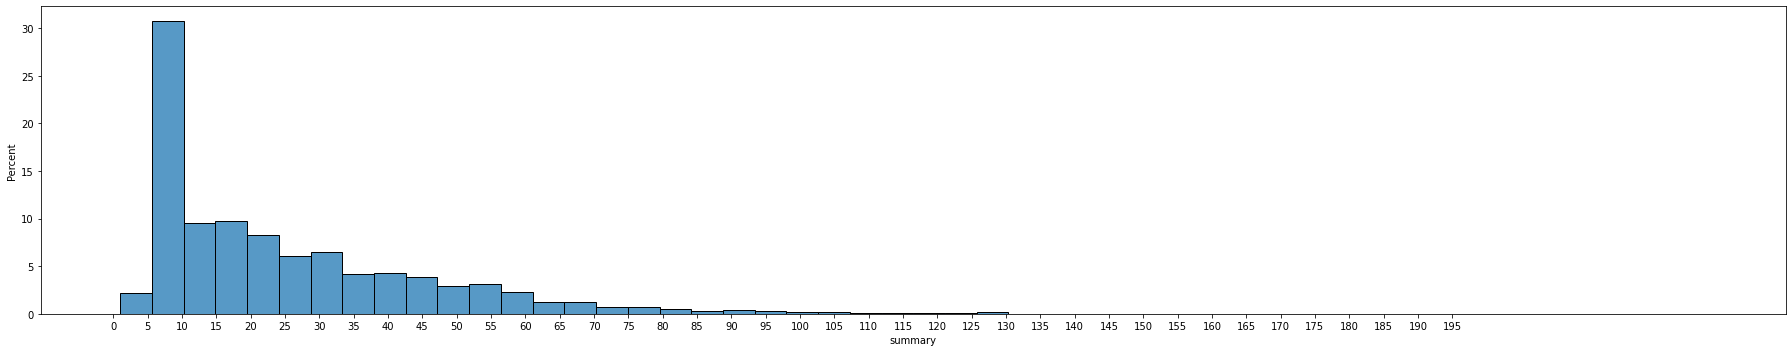

In [28]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.set_xticks(range(0, 200, 5))
sns.histplot(data_df["summary"].str.len(), stat="percent", bins=50, ax=ax)
fig.tight_layout()

In [29]:
mean_length = round(np.mean(data_df["summary"].str.len()))
print("mean summary length:", mean_length, "characters")

data_df[data_df["summary"].str.len() == mean_length]["summary"].head(30)

mean summary length: 26 characters


10      Very useful for some tasks
18      It Works with Windows XP!!
26      ICS function will not work
235     Works just like it should!
253     You can flip the direction
272     Easy fix for extra cooling
273     Suprisingly great air flow
277     Great product, Great Price
306     Somewhat noisy, but works.
386     Excellent streaming device
642     The product have problem..
703     Decent range for the price
727     Old as heck, but it works.
755     Best buy for PC 133 SD RAM
771     Generic SDRAM Works Great!
884     A fan of this purchase <.<
898     Brainlessly simple install
1067    Wrong brand and defective.
1138    good value, GREAT product!
1151    Exactly what my PC needed!
1162    Good Product for the price
1219    very worthwhile investment
1241    Not reliable unfortunately
1244    Great addition to slow PC.
1245    PC270 184 pin 512MB memory
1310    Very Easy To Install & Use
1314    Perfect match for any Mac!
1352    Great Memory for the Price
1388    sped up my I

In [30]:
# top 3 most common summary length
len10 = set(data_df[data_df["summary"].str.len() == 10]["summary"].head(20))
len11 = set(data_df[data_df["summary"].str.len() == 11]["summary"].head(20))
len9 = set(data_df[data_df["summary"].str.len() == 9]["summary"].head(20))

print(len10, "\n\n", len11, "\n\n", len9)

{'Five Stars', 'I love it!', 'old memory', 'its memory', 'Four Stars', 'Works well'} 

 {'Works good.', 'Worked fine', 'No problems', 'Think twice', 'Works Great', 'pretty good', 'Works great', 'BAD. AVOID.', 'Fanless Fan', 'Very noisy.', 'works great', 'cool man !!', 'Three Stars', 'Outstanding', 'Great RAM !', 'great value'} 

 {'Two Stars', "Don't buy", "it's okay", 'Great fan', 'Good Deal', 'FANTASTIC', 'Great fx.', 'Beautiful', 'Great Fan', 'great fan', 'High flow', 'No workie'}


/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


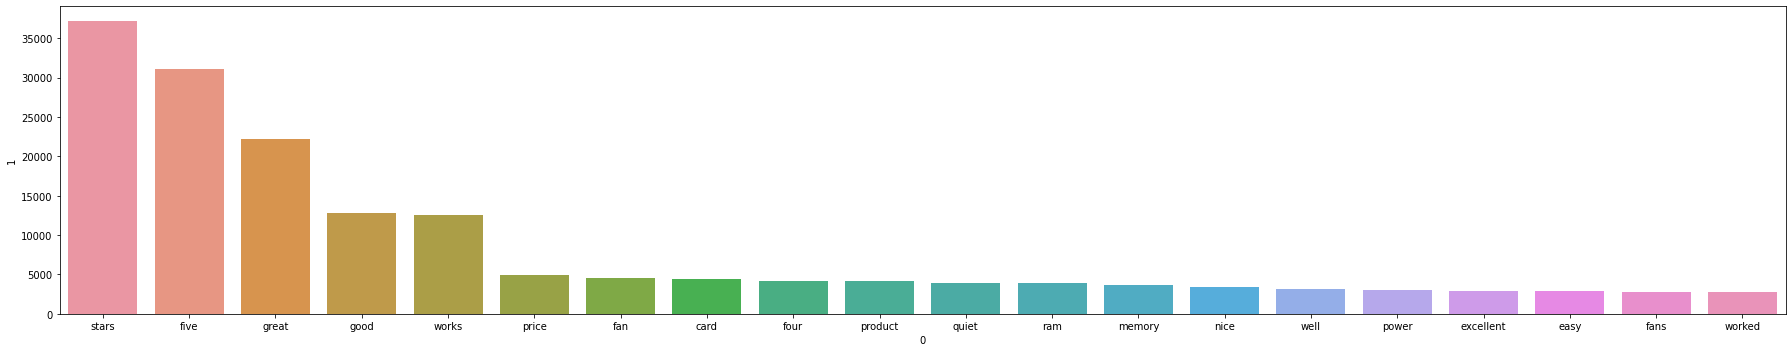

In [32]:
# most common tokens summary
tokens = []
for x in data_df["summary"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)
fig.tight_layout()

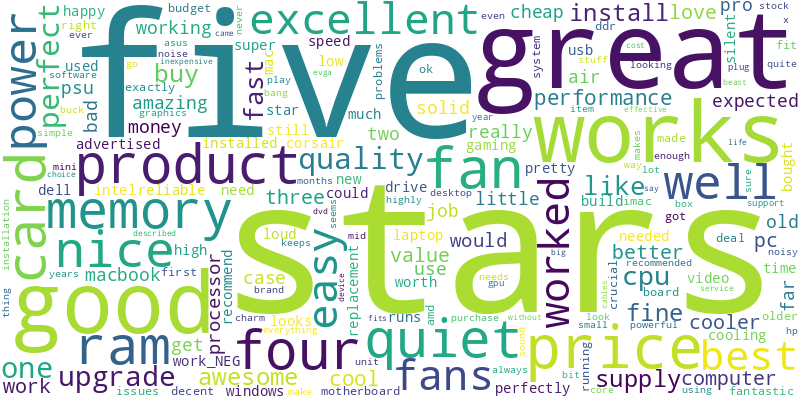

In [33]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Text

In [34]:
data_df["text"].head(20)

0     This sound card doesn't reproduce MP3 or WAV f...
1     Essentially, this is the entry-level, 16-bit a...
2     This is a basic sound card.  Nothing fancy.  T...
3     This is a basic low-end sound card. It puts ou...
4     Ordered these by mistake. My computer didn't n...
5     I installed per instructions, beign always gro...
6     I have owned other sound blaster sound cards. ...
7     This pci card works but unfortunatly i needed ...
8     I keep a lot of computer equipment at home, du...
9     First time I plugged it in and installed the d...
10    The Dazzle Multimedia DM4100 Digital Video Cre...
11    The USB version of the Dazzle DM4100 video cap...
12    If you want to convert your VHS video tapes in...
13    Ignore all the unfavorable reviews of the Dazz...
14    What happens, is that PCI TV cards clog up you...
15    I purchased the lower end version of this prod...
16    I've probably invested more than ten hours int...
17    This was a good starter card for watching 

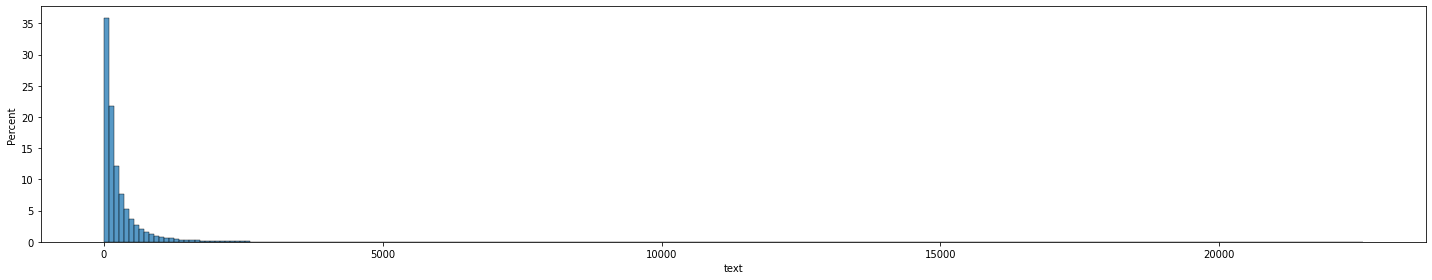

In [51]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.histplot(data_df["text"].str.len(), stat="percent", bins=250, ax=ax)
fig.tight_layout()

In [52]:
mean_length = round(np.mean(data_df["text"].str.len()))
print("mean text length:", mean_length, "characters")

data_df[data_df["text"].str.len() == mean_length]["text"].head(10)

mean text length: 286 characters


250     This blower is amazing!  It does move a lot of...
3327    This processor is very nice, it works very wel...
4111    Switching power supply is common for computers...
4368    This fan is very bulky.  Make sure you have pl...
5795    I purchased this ram upgrade for my late 2007 ...
6309    Orignially I bought this for usb driving. Unfo...
7430    Not sure what else to say - they work, and are...
8692    I was upgrading the RAM in my 2007-2008 white ...
8778    I have used Crucial me,ory in the past and hav...
9411    this thing is a monster and thats all that nee...
Name: text, dtype: string

In [53]:
# top 3 most common text length
len9 = set(data_df[data_df["text"].str.len() == 9]["text"].head(10))
len12 = set(data_df[data_df["text"].str.len() == 12]["text"].head(10))
len11 = set(data_df[data_df["text"].str.len() == 11]["text"].head(10))

print(len9, "\n\n", len12, "\n\n", len11)

{'Excellent', 'excellent', 'thank you', 'very loud', 'It is ok.', 'Very Good', 'good deal', 'expensive'} 

 {'Still works.', 'No problems.', 'As described', 'Good Product', 'worked great', 'as described', 'Good product'} 

 {'Works great', 'good memory', 'As Expected', 'works great', 'Great deal!', 'Works well.', 'didnot work'}


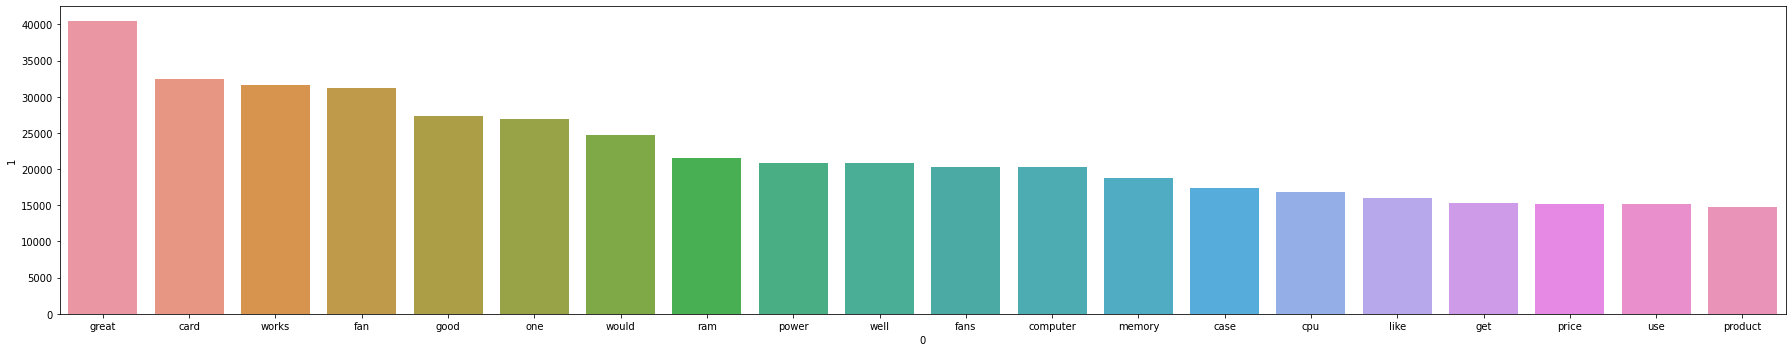

In [56]:
# most common tokens summary
tokens = []
for x in data_df["text"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

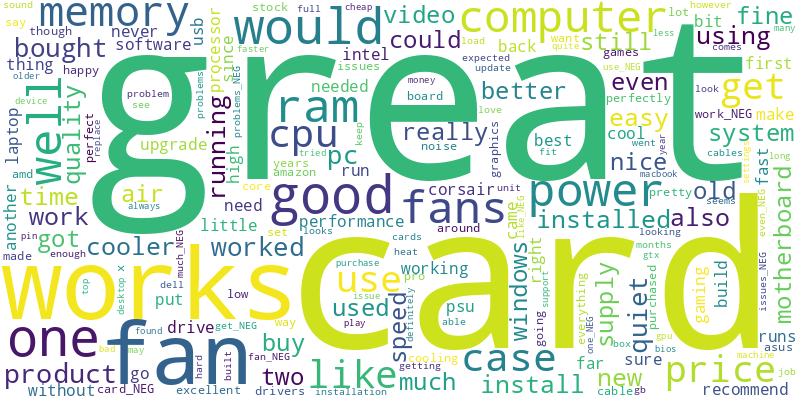

In [57]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### SUMMARY + TEXT

In [58]:
summary_text = []
for i, row in data_df.iterrows():
    end_line = ".\n"
    if row["summary"].endswith("."):
        end_line = "\n"
    summary_text.append(row["summary"] + end_line + row["text"])
data_df["summary+text"] = summary_text

for i in range(3):
    print(data_df["summary+text"][i], "\n")

Easy to Use, Almost everything you could want.
This sound card doesn't reproduce MP3 or WAV files any differently than a more expensive card would.  Creative Labs has always made great cards and drivers.  The only thing this card doesn't give you that the more expensive card do is the 3d sound effects when playing video games, and true Dolby 5.1 for DVD playback.  However, I doubt many people are setup for this situation, and many people do not watch DVD's or play games.  If this is you, this card is perfect for you.  If you are a gamer then this card will work perfectly fine.  I personally find the 3d effects annoying, and prefer to play on a card like this.  I highly recomend this card. 

Bathtub.
Essentially, this is the entry-level, 16-bit audio Creative Labs sound  card. It has a built-in mock '3D' stereo effect, a 128-voice MIDI  wavetable, and it can sample at up to 48khz in 16-bit stereo, and that's  about all there is to it. Whilst it doesn't do anything wrong in itself  (it's

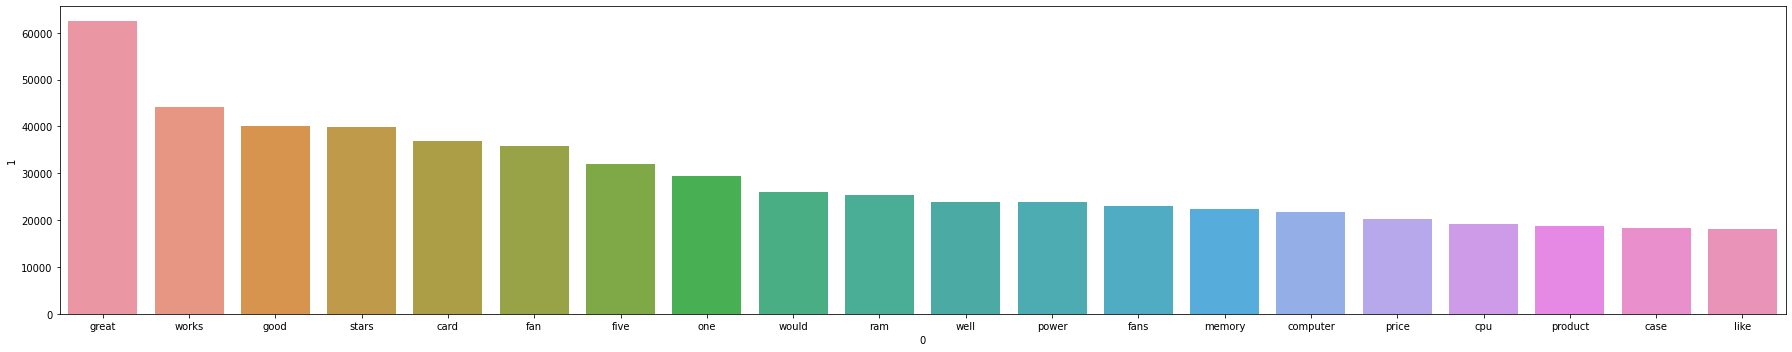

In [59]:
# most common tokens summary
tokens = []
for x in data_df["summary+text"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

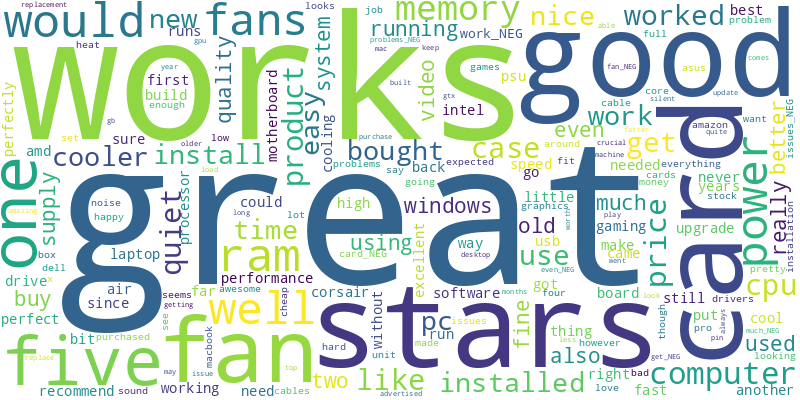

In [60]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

# Overall

<AxesSubplot:ylabel='overall'>

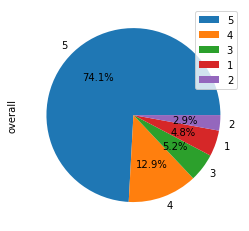

In [91]:
# number by starts
data_df["overall"].value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

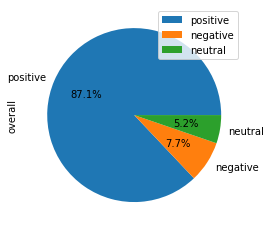

In [92]:
# ground truth polarity
polarity_overall = data_df["overall"].parallel_apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)
polarity_overall.value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)
pass

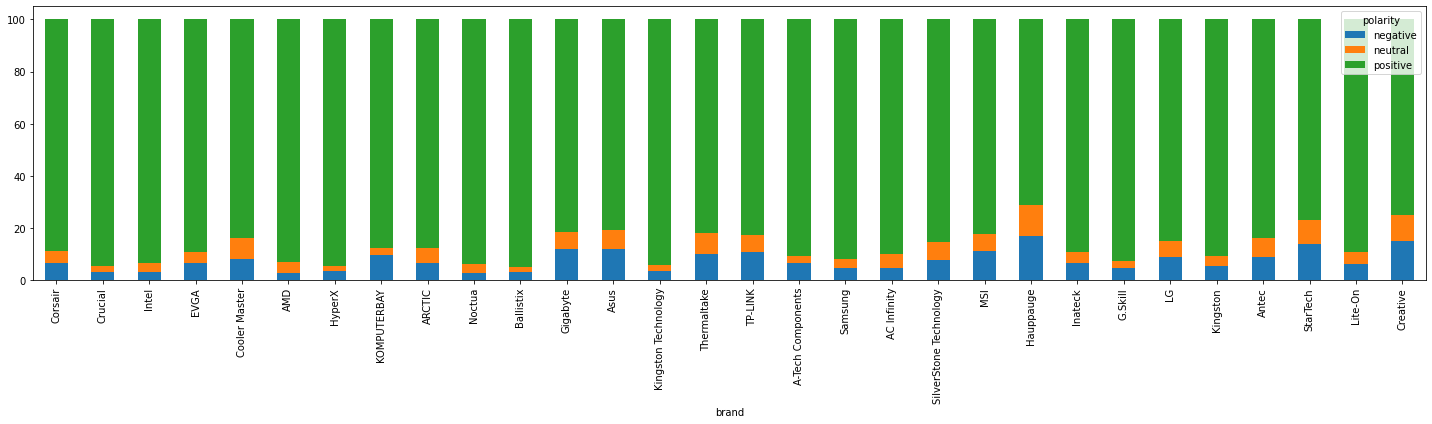

In [95]:
fig, ax = plt.subplots(figsize=(20, 6))

data = pd.DataFrame(Counter(data_df["brand"]).most_common(30))

data = data_df.loc[data_df["brand"].isin(set(data[0]))]
x = (
    data[["brand", "polarity_overall"]]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index(name="count")
)
x = x.pivot(columns="polarity", index="brand", values="count")

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

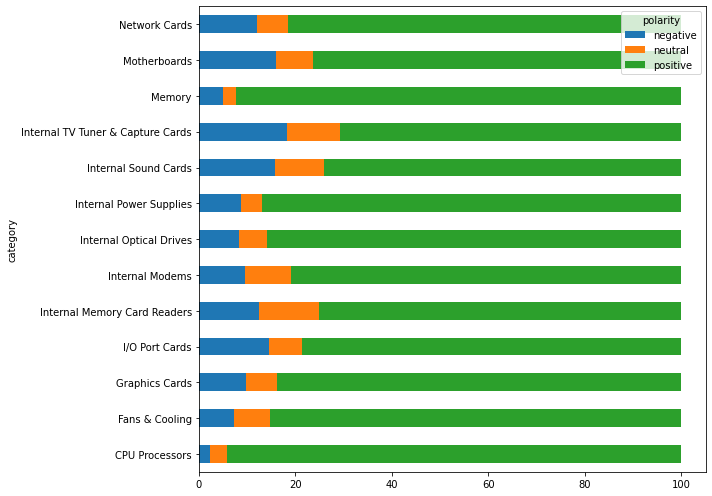

In [66]:
fig, ax = plt.subplots(figsize=(10, 7))

data_df["polarity_overall"] = polarity_overall
x = (
    data_df.groupby("category")["polarity_overall"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="polarity_overall")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

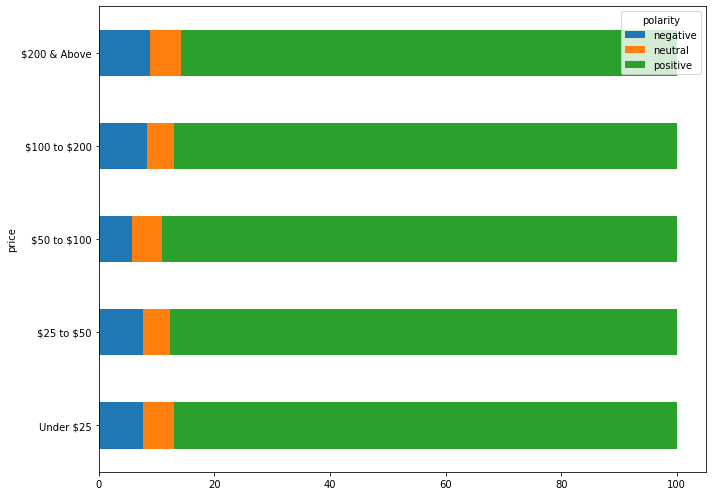

In [67]:
fig, ax = plt.subplots(figsize=(10, 7))

data_df["new_price"] = new_price
x = (
    data_df.groupby("new_price")["polarity_overall"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="polarity_overall")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

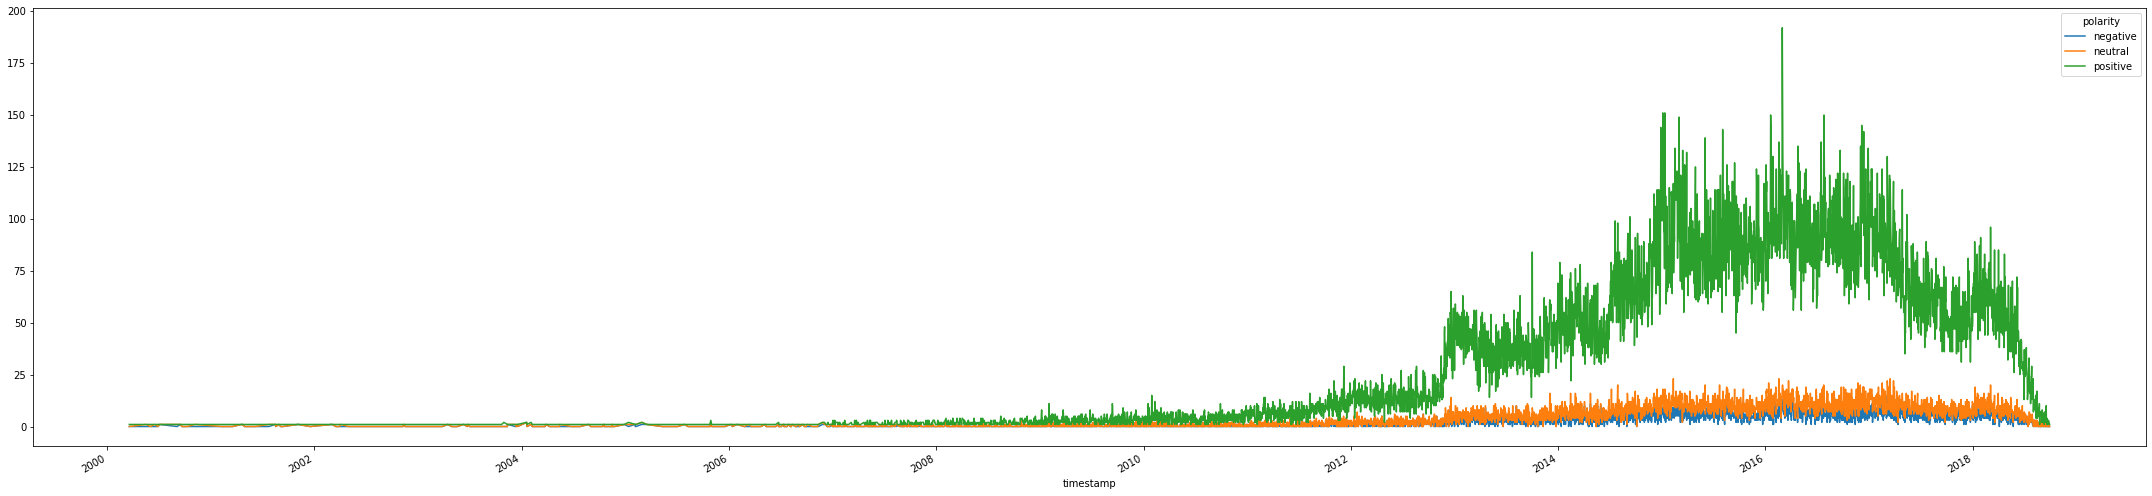

In [68]:
# Overall over time

fig, ax = plt.subplots(figsize=(30, 7))
plt.xticks(rotation=90)

x = (
    data_df.groupby("timestamp")["polarity_overall"]
    .value_counts()
    .rename_axis(["timestamp", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="timestamp", values="polarity_overall")
)
x.reset_index(inplace=True)

x.plot(x="timestamp", kind="line", stacked=True, ax=ax)
fig.tight_layout()

# Vote

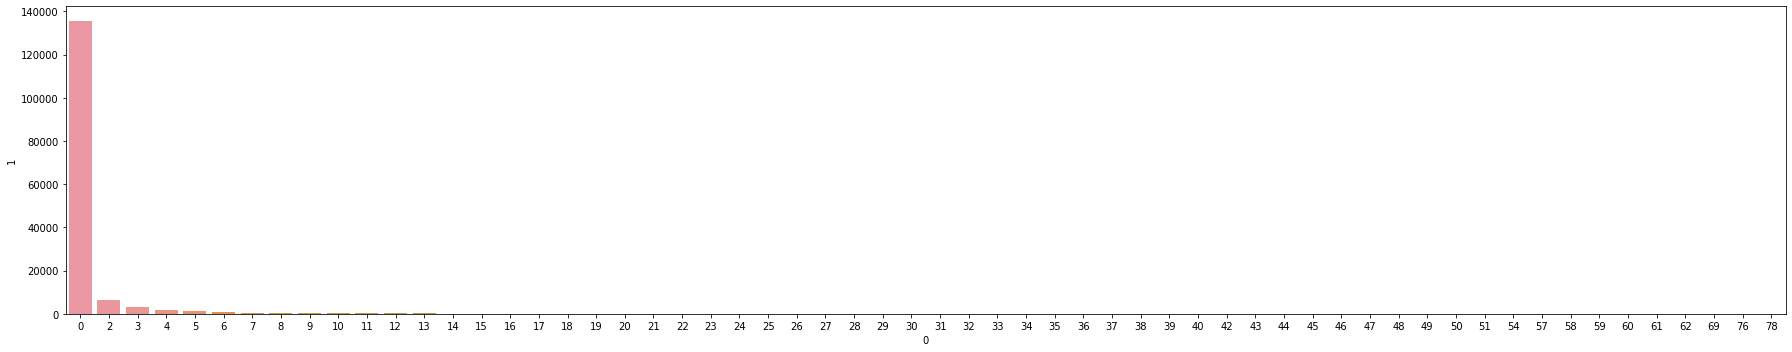

In [69]:
# count of helpful vote number

data = pd.DataFrame(Counter(data_df["vote"].tolist()).most_common(60))
fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

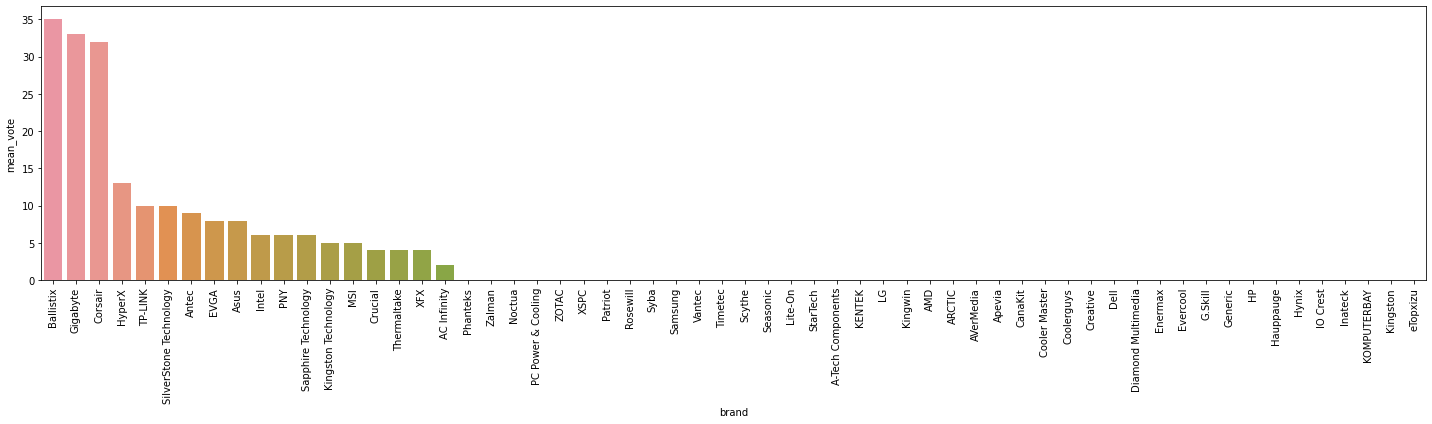

In [78]:
# mean number of util vote for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(60))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(
    x=df["brand"],
    y=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).brand,
)
plt.xticks(rotation=90)
fig.tight_layout()

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


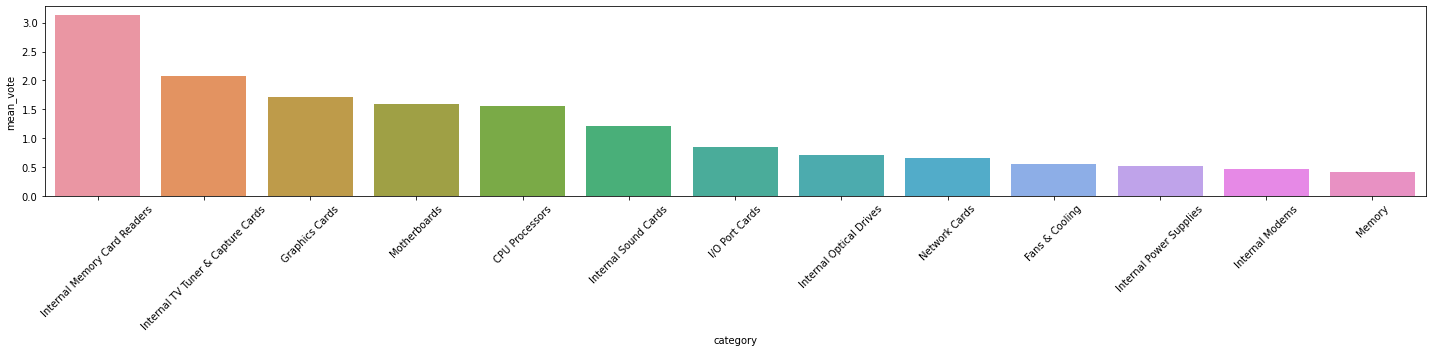

In [83]:
# mean number of util vote for category

df = data_df.copy()
df = df.groupby(["category"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(
    df["category"],
    df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).category,
)
plt.xticks(rotation=45)
fig.tight_layout()

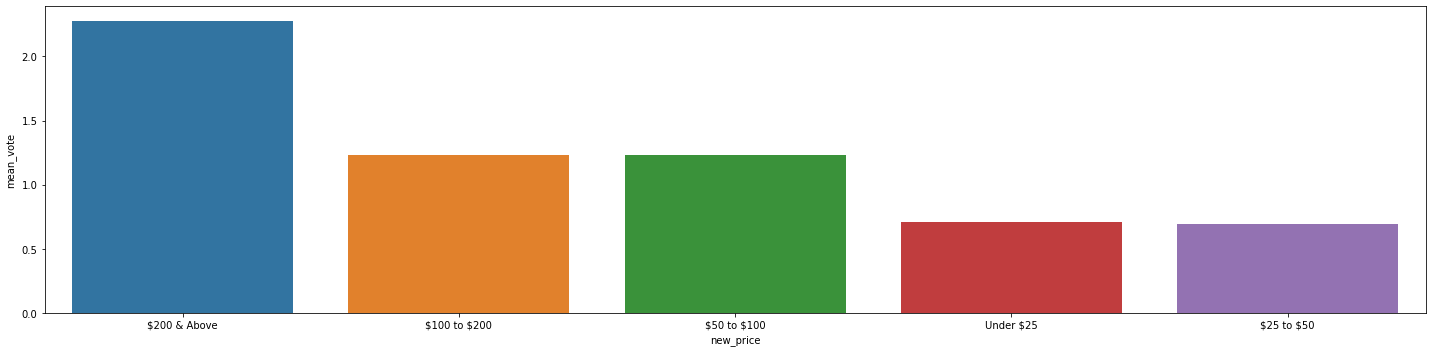

In [87]:
# mean number of util vote for price

df = data_df.copy()
df["new_price"] = new_price

df = df.groupby(["new_price"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(
    x=df["new_price"],
    y=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).new_price,
)
fig.tight_layout()